In [147]:
import numpy as np
from numpy import sin
import holidays
from numpy.linalg import inv
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from random import random
from random import sample
%matplotlib inline

In [348]:
def get_weights(A, y):
    return np.linalg.pinv(A)@y
    #return inv(A.T@A)@A.T@y

In [382]:
def get_error(A_train, A_test, y_train, y_test):
    w = get_weights(A_train, y_train)
    Y = A_test@w
    r = y_test - Y
    return np.sqrt(np.mean((y_test - Y)**2))

In [234]:
data = pd.read_excel("/home/andreizoltan/ml/1/EnergyConsumption.xls")
print("Данные по энергопотреблению за {}".format(data['Date'].max()-data['Date'].min()))
data.head()

Данные по энергопотреблению за 364 days 23:00:00


,Date,WeekDay,Hour,ConsumprionMWtH,TemperatureC
0,2005-01-01 00:00:00,6,00:00:00,1289.617859,-10.676569
1,2005-01-01 01:00:00,6,01:00:00,1265.573853,-12.041959
2,2005-01-01 02:00:00,6,02:00:00,1273.188232,-13.198006
3,2005-01-01 03:00:00,6,03:00:00,1279.703979,-13.999279
4,2005-01-01 04:00:00,6,04:00:00,1292.839539,-14.782819


In [235]:
n_train = int(0.8*data.shape[0])
data_train = data[:n_train]
data_test = data[n_train:]

In [319]:
h_train = data_train['Hour'].apply(lambda x: x.hour)
d_train = data_train['WeekDay']
m_train = data_train['Date'].apply(lambda x: x.dayofyear)
t_train = data_train['TemperatureC']
y_train = data_train['ConsumprionMWtH']
x_train = np.linspace(0, 1, y_train.shape[0])

In [320]:
h_test = data_test['Hour'].apply(lambda x: x.hour)
d_test = data_test['WeekDay']
m_test = data_test['Date'].apply(lambda x: x.dayofyear)
t_test = data_test['TemperatureC']
y_test = data_test['ConsumprionMWtH']
x_test = np.linspace(0, 1, y_train.shape[0])

### нормировка

In [321]:
h_train = (h_train - np.mean(h_train))/np.std(h_train)
d_train = (d_train - np.mean(d_train))/np.std(d_train)
m_train = (m_train - np.mean(m_train))/np.std(m_train)
t_train = (t_train - np.mean(t_train))/np.std(t_train)
y_train = (y_train - np.mean(y_train))/np.std(y_train)

In [322]:
h_test = (h_test - np.mean(h_train))/np.std(h_train)
d_test = (d_test - np.mean(d_train))/np.std(d_train)
m_test = (m_test - np.mean(m_train))/np.std(m_train)
t_test = (t_test - np.mean(t_train))/np.std(t_train)
y_test = (y_test - np.mean(y_train))/np.std(y_train)

In [366]:
A_train = get_model_matrix(h_train, d_train, m_train, t_train, holiday_train)
A_test = get_model_matrix(h_test, d_test, m_test, t_test, holiday_test)

In [238]:
def is_holiday(day):
    russia_holidays = holidays.Russia()
    day = day.date()
    if day in russia_holidays:
        return 1
    else:
        return -1

In [365]:
ones = np.ones(y_train.shape[0])
holiday_train = data['Date'][:x_train.shape[0]].apply(lambda x: is_holiday(x))
holiday_test = data['Date'][x_train.shape[0]:].apply(lambda x: is_holiday(x))
omega = 2*np.pi/(2/365)
def get_model_matrix(h, d, m, t, holiday):
    ones = np.ones(h.shape[0])
    A = np.column_stack((ones, h, h**2, np.arcsinh(h), np.log(abs(h)), h*np.sqrt(abs(h)),\
                     sin(omega*h + 0.2), sin(omega*h/2), sin(omega*h*4),\
                     d, d**2, sin(327*d), sin(250*d),np.sin(29*d),\
                     m, m**2, m**3, sin(m), np.log(abs(m)+1),          \
                     t, t**3, np.sinh(t), np.log(abs(t)),\
                     holiday
                     ))
    return A

In [308]:
B = get_model_matrix(h, d, m, t, holiday)

### Let set the parameters of the algorithm

In [328]:
P = 20
Q = 5
R = 40
n = A_train.shape[1]

### 1. Choose population

In [330]:
A_population = np.random.randint(low=0, high=2, size=(P, n))

### 2. get 2 vectors

In [331]:
p, q = sample(range(n), 2)
a, b = A_population[p], A_population[q]

### 3. choose random number $\nu$

In [332]:
u = np.random.randint(n)

### 4. split both vectors and change their parts

In [333]:
def swap(a, b, u):
    return np.concatenate((b[:u], a[u:])), np.concatenate((a[:u], b[u:]))

In [334]:
a, b = swap(a, b, u)

### 5. choose random numbers $\eta_{1}, ..., \eta_{Q}$

In [335]:
ns = sample(range(n), Q)

### 6. invert positions $\eta_{1}, ..., \eta_{Q}$ of the vectors a', b'

In [336]:
def swap_positions(a, b, ns):
    for i in ns:
        a[i], b[i] = b[i], a[i]
    return a, b

In [337]:
a, b = swap_positions(a, b, ns)

### 7. repeat 2-6 P/2 times

In [445]:
def from2to6(A):
    N = A.shape[0]
    p, q = sample(range(N), 2)               # first step
    a, b = A[p], A[q]
    n = a.shape[0]
    u = np.random.randint(n)                 # second step
    a, b = swap(a, b, u)                     # third step
    ns = sample(range(n), Q)                 # fourth step
    a, b = swap_positions(a, b, ns)          # fifth step
    return a, b

### 8. evaluate obtained models and repeate R times

In [482]:
A_population = np.random.randint(low=0, high=2, size=(P, n))
R = 10
error_plt = list()
for i in range(R):
    A_add = list()
    for _ in range(int(P/2)):
        a, b = from2to6(A_population)
        A_add.append(a)
        A_add.append(b)
    A_population = np.vstack((A_population, A_add))
    del_models = list()
    for idx, j in enumerate(range(int(2*P))):
        error = get_error(A_population[j]*A_train, A_test, y_train, y_test)
        del_models.append([idx, error])
    del_models = sorted(del_models, key=lambda x: x[1])
    print(del_models[0][1])
    error_plt.append(del_models[0][1])
    A_population = np.delete(A_population, del_models[P:], axis=0)

1116.342987253135


/home/andreizoltan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/andreizoltan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


1099.3622531822746
1099.3622531822746
1042.631833367263
1005.1304848551599
964.2715225858076
747.833735952568
736.3611777352338
736.025134501349
736.025134501349


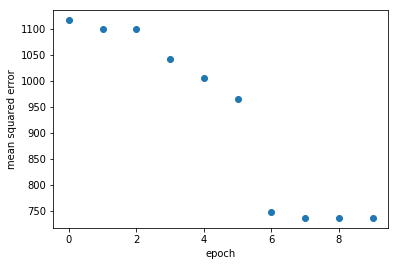

In [485]:
plt.scatter(range(R), error_plt)
plt.xlabel("epoch")
plt.ylabel("mean squared error")
plt.show()